In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calculate_precision, calculate_recall
import gc
from tqdm import tqdm_notebook
from functools import reduce

In [2]:
# available for test:
# 20921, 20916, 20761, 20755, 20754, 20743, 20717, 20323
# 1921, 1911, 1899, 1831, 1826, 1813, 1808, 704, 702, 635, 628, 626, 615, 593,
# 456, 454, 435, 432, 411, 401, 309, 308, 305, 302, 239, 228, 231, 200, 158, 150, 
# 126, 119, 118, 117, 116, 115, 114, 113

# available for experiments:
# 114, 115, 116, 117, 119, 302, 303, 304, 305, 306, 307,
# 308, 309, 393, 442, 470, 471, 472, 502, 503, 504, 505,
# 506, 507, 508, 511, 512, 513, 514, 515, 516, 591, 592,
# 593, 596, 597, 599, 612, 613, 614, 615, 616, 617, 618,
# 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629,
# 836, 837, 838, 839, 862, 863, 874, 875, 888, 1820, 1832,
# 1833, 1834, 1835, 1836, 1838, 1896, 1899, 4007

# small outliers:
# 114, 119, 302, 303, 442, 511, 512, 514, 629, 838, 839

# big bugs
# 307, 393, 503, 504, 505, 516, 619, 1838, 1896 -- big bugs

## Loading data

In [ ]:
%%time
test_station_id = [113, 114, 115, 116, 117, 118, 119, 126, 150]
                   #[20921, 20916, 20761, 20755, 20754, 20743, 20717, 20323, 
                   #1921, 1911, 1899, 1831, 1826, 1813, 1808, 704, 702, 635,
                   #628, 626, 615, 593, 456, 454, 435, 432, 411, 401, 
                   #309, 308, 305, 302, 239, 228, 223, 200, 152, 150,
                   #126, 119, 118, 117, 116, 115, 114, 113]


train_station_id = [456, 454, 435, 432, 411, 401, 309, 308, 305, 302, 239, 228, 200, 152, 150, 
                    126, 119, 118, 117, 116, 115, 114, 113,
                    514, 515, 516, 592, 593, 596, 597, 599, 612] 
#                    613, 614, 616, 617, 618, 619, 620, 621, 622, 623, 
#                    624, 625, 627, 629, 836, 837, 838, 839, 862, 863, 
#                    874, 875, 888, 1820, 1832, 1833, 1834, 1835, 1836, 
#                    1838, 1896, 4007]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

## Add labels to test

In [4]:
#test['label_true'] = get_labels(test, labels_type='true')
test['label_true'] = np.random.binomial(1, 0.05, len(test))
test['label_predict'] = np.random.binomial(1, 0.2, len(test))

## Calculate Precision

In [5]:
#df = test[test['station_id'].isin((113, 114, 115, 116, 117, 118, 119))]
precision = calculate_precision(test)
recall = calculate_recall(test)
print(precision, recall)

0.3791567018288992 0.8710413470238798


## Clean data

In [ ]:
loaded_valid_train_ids = []
for station_id in train_station_id:
    raw = pd.read_csv(data_directory + '/Labels/Clean/' + str(station_id) + '_valid.csv', index_col=False, header=None)
    loaded_valid_train_ids.append(raw)

valid_train_ids = pd.concat(loaded_valid_train_ids)
valid_train_ids = list(valid_train_ids.values.ravel())
train['clean'] = train[MmxColumns.ID_ROAD_TEMPERATURE].isin(valid_train_ids)
train = train[train['clean']]
del train['clean']

## Feature selection

In [6]:
def create_data(df):
    df_res = pd.DataFrame(index=df.index)
    df_res['date_time_utc'] = copy(df['date_time_utc'])
    df_res['station_id'] = copy(df['station_id'])
    for column in [col for col in df.columns if col.startswith('data_')]:
        #print(column)
        df_res['{0}'.format(column)] = copy(df[column])
        if column not in ('data_latitude', 'data_longitude', 
                         'data_solar_altitude', 'data_solar_azimuth', 'data_road'):
            #print(column)
            df_res['{0}_lag_1'.format(column)] = df_res['{0}'.format(column)].shift(2) 
            df_res['{0}_lag_2'.format(column)] = df_res['{0}'.format(column)].shift(3)
            df_res['{0}_lag_3'.format(column)] = df_res['{0}'.format(column)].shift(4)
            df_res['{0}_lag_4'.format(column)] = df_res['{0}'.format(column)].shift(5)
            df_res['{0}_lag_5'.format(column)] = df_res['{0}'.format(column)].shift(6)
            df_res['{0}_lag_6'.format(column)] = df_res['{0}'.format(column)].shift(7)
            df_res['{0}_lag_7'.format(column)] = df_res['{0}'.format(column)].shift(8)
            #df_res['{0}_lag_8'.format(column)] = df_res['{0}'.format(column)].shift(8)
        
            #if column not in ('solar_altitude', 'solar_azimuth'):
            #df_res['{0}_diff_12'.format(column)] = df_res['{0}_lag_1'.format(column)] \
            #                                        - df_res['{0}_lag_2'.format(column)]
            df_res['{0}_diff_23'.format(column)] = df_res['{0}_lag_2'.format(column)] \
                                                    - df_res['{0}_lag_3'.format(column)]
            df_res['{0}_diff_34'.format(column)] = df_res['{0}_lag_3'.format(column)] \
                                                    - df_res['{0}_lag_4'.format(column)]
            df_res['{0}_diff_45'.format(column)] = df_res['{0}_lag_4'.format(column)] \
                                                    - df_res['{0}_lag_5'.format(column)]
            #df_res['{0}_diff_56'.format(column)] = df_res['{0}_lag_5'.format(column)] \
            #                                       - df_res['{0}_lag_6'.format(column)]
            #df_res['{0}_diff_67'.format(column)] = df_res['{0}_lag_6'.format(column)] \
            #                                        - df_res['{0}_lag_7'.format(column)]
            #df_res['{0}_diff_78'.format(column)] = df_res['{0}_lag_7'.format(column)] \
            #                                        - df_res['{0}_lag_8'.format(column)]
            if column != 'data_t_road':
                del df_res['{0}'.format(column)]
    
    #df_res.set_index('date_time', inplace=True)
    df_res['data_dayofyear_cos'] = np.cos(df_res['date_time_utc'].dt.dayofyear / 365 * np.pi)

    df_res['data_dayofyear_sin'] = np.sin(df_res['date_time_utc'].dt.dayofyear / 365 * np.pi)

    df_res['data_hour_cos'] = np.cos(df_res['date_time_utc'].dt.hour / 24 * np.pi)

    df_res['data_hour_sin'] = np.sin(df_res['date_time_utc'].dt.hour / 24 * np.pi)

    df_res['data_month_cos'] = np.cos(df_res['date_time_utc'].dt.month / 12 * np.pi)

    df_res['data_month_sin'] = np.sin(df_res['date_time_utc'].dt.month / 12 * np.pi)
    df_res = df_res.fillna(0)
    return df_res

In [7]:
import xgboost as xgb

point = pd.Timestamp(2015, 6, 1)

train = train.dropna()
X_train = create_data(train[train['date_time_utc'] < point])
y_train = train.loc[train['date_time_utc'] < point, 'data_t_road']

features = [col for col in X_train if col.startswith('data_') and (col!='data_t_road')]

X_train = X_train[features]

X_train = np.array(X_train[features].values, dtype=np.float32)
y_train = np.array(train.loc[train['date_time_utc'] < point, 'data_t_road'].values.reshape(-1, 1), dtype=np.float32) #.reshape(-1, 1)

X_valid = create_data(train[train['date_time_utc'] >= point])
X_valid = np.array(X_valid[features].values, dtype=np.float32)
y_valid = np.array(train.loc[train['date_time_utc'] >= point, 'data_t_road'].values.reshape(-1, 1), dtype=np.float32) #.reshape(-1, 1)

X_test = create_data(test)
X_test = np.array(X_test[features].values)
y_test = np.array(test['data_t_road'].values.reshape(-1, 1)) # .reshape(-1, 1)


dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_valid, y_valid)
dtest = xgb.DMatrix(X_test, y_test)

In [ ]:
#from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from functools import partial

params = {}

params["eval_metric"] = 'mae'
params["eta"] = 0.05
params["lambda"] = 0.5
params["subsample"] = 0.8
params["min_child_weight"] = 1.
params["colsample_bytree"] = 0.5
params["max_depth"] = 8
params["silent"] = 1
params["gamma"] = 0.1
delta = 1.
watchlist = [(dtrain, 'train'), (dval, 'valid')]

clf = xgb.train(params, dtrain, 400, watchlist, verbose_eval=20)

[0]	train-mae:12.5742	valid-mae:12.186
[20]	train-mae:4.56444	valid-mae:4.42001
[40]	train-mae:1.74661	valid-mae:1.69112
[60]	train-mae:0.861549	valid-mae:0.847717
[80]	train-mae:0.646317	valid-mae:0.650033
[100]	train-mae:0.594815	valid-mae:0.606601
[120]	train-mae:0.576933	valid-mae:0.594012
[140]	train-mae:0.566522	valid-mae:0.586751


In [22]:
y_true = dtest.get_label()
y_pred = clf.predict(dtest).ravel()
upper = y_pred + 0.48 * 10
lower = y_pred - 0.48 * 10
test['label_predict'] = ((y_true > upper) | (y_true < lower))

/home/ndsviriden/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/ndsviriden/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [28]:
type(y_pred[100])

numpy.float32

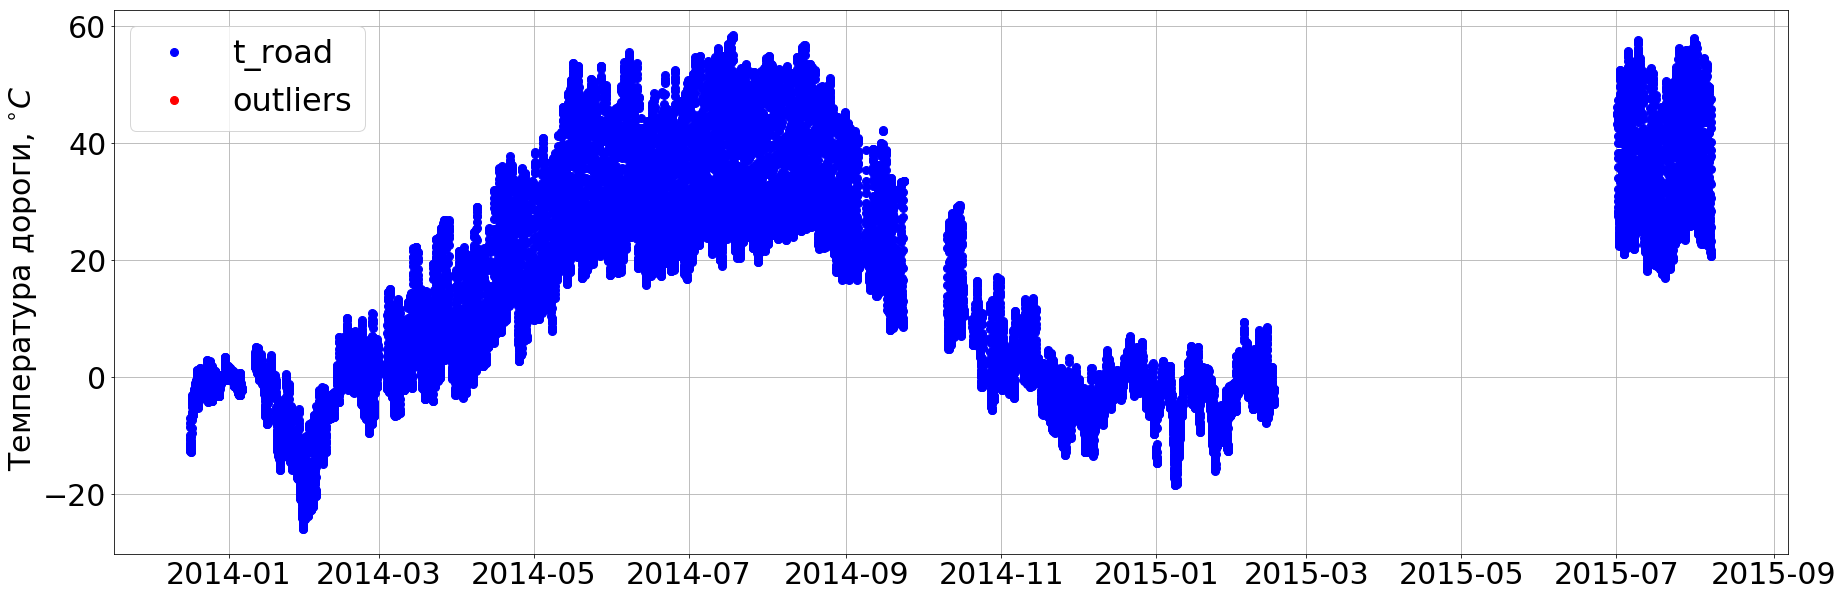

In [135]:
import matplotlib.pyplot as plt

start = pd.Timestamp(2012, 7, 5)
end = pd.Timestamp(2017, 7, 11)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond = (to_plot['label_true'] == 0) == elem
    if elem:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)
plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()